This script runs the functions included in crevMathFuncs.py on example data sets to provide the calculations used in submitted paper: <br />
"Comprehensive Assessment of Stress Calculations for Crevasse Depths and Testing with Crevasse Penetration as Damage" 

crevMathFuncs.py contains three functions: <br />
1. AofT: calculates the flow coefficient, A, for Glen's flow law using the piecewise function in Cuffey and Patterson (2010).
2. nyeCrevassesAF: calculates surface crevasse depths and basal crevasse heights with the Nye formulation for calculatoins A to F. Uses AofT function.
3. calcPenRatio: calculates the crevasse penetratoin ratio from surface crevasse depth, basal crevasse height, and thickness. Clips max to 1.0.

Author: Ben Reynolds (July 3, 2024)

User input in below cell. Premade options are: <br />
1. 'larB_2014_2017.nc' = Larsen B remnant with bedmachine surface elevation / thickness and MEaSUREs 2014-2017 velocity mosaic <br />
2. 'PIG_2015.nc' = Pine Island Glacier's ice shelf with bedmachine surface elevation / thickness and ITS_LIVE 2015 velocity mosaic

In [1]:
# data input 

# Uncomment (delete apostraphes) below for larsen B

fi_in = 'LarB_2014_2017.nc'
x_min = -2380e3
x_max = -2310e3
y_min = 1215e3
y_max = 1285e3


# Uncomment below for Pine Island Glacier's Shelf
'''
fi_in = 'PIG_2015.nc'
x_min = -1650e3
x_max = -1550e3
y_min = -350e3
y_max = -250e3
'''

# physical variables
rho_i = 917 # ice density (kg/m^3)
rho_pw = 1027 # proglacial (ocean) water density (kg/m^3)
g = 9.81 # grav accel (m/s^2)

In [2]:
# import libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

# import custom functions
from crevMathFuncs import nyeCrevassesAF # this function takes in velocity and outputs crevasse depth / height with the Nye formulation
from crevMathFuncs import calcPenRatio # this function calculates the penetration ratio from crevasse sizes and thickness and clips to <= 1.0

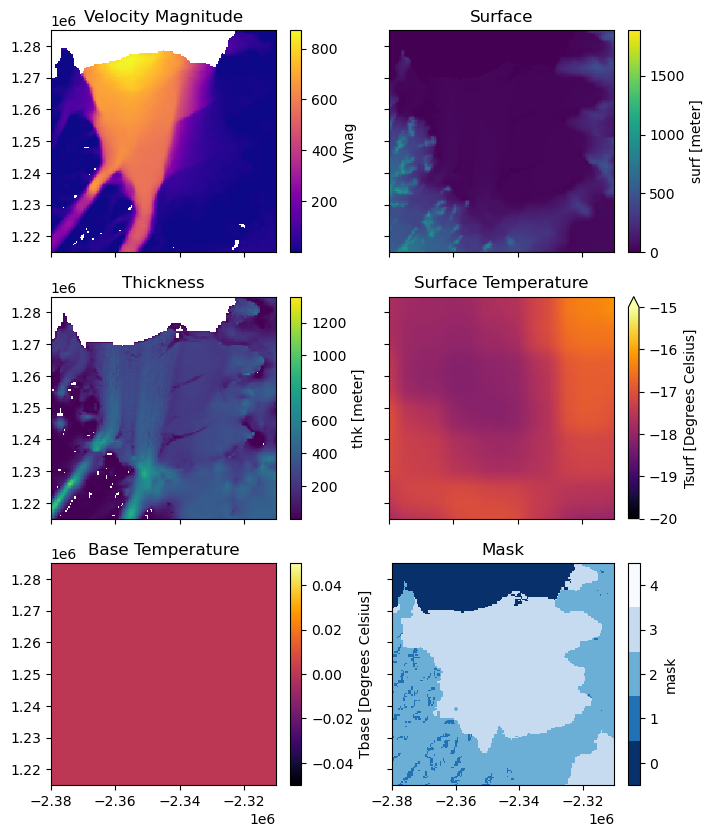

In [3]:
# load and plot the example data

# open the netCDF with xarray
data_xr = xr.open_dataset(fi_in, decode_times=False) 

# calculate velocity magnitude for plotting
data_xr['Vmag'] = np.sqrt(data_xr.VX**2 + data_xr.VY**2)

# Plot data inputs
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,10))
data_xr.Vmag.plot(ax=axs[0,0],cmap=plt.cm.plasma)
axs[0,0].set_title('Velocity Magnitude')

data_xr.surf.plot(ax=axs[0,1],cmap=plt.cm.viridis)
axs[0,1].set_title('Surface')

data_xr.thk.plot(ax=axs[1,0],cmap=plt.cm.viridis)
axs[1,0].set_title('Thickness')

data_xr.Tsurf.plot(ax=axs[1,1],cmap=plt.cm.inferno,  vmin=-20, vmax=-15)
axs[1,1].set_title('Surface Temperature')

data_xr.Tbase.plot(ax=axs[2,0],cmap=plt.cm.inferno)
axs[2,0].set_title('Base Temperature')

cmap_mask = plt.get_cmap('Blues_r', 4 - 0 + 1)
mask_plt = data_xr.mask.plot(ax=axs[2,1],cmap=cmap_mask, vmin=0 - 0.5, vmax=4 + 0.5)
axs[2,1].set_title('Mask')
#plt.colorbar(mask_plt, ticks=np.arange(0, 4 + 1))

# reomve axis labels
for i in range(0,3):
    for j in range(0,2):
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')

# set axis bounds
axs[2,1].set_xlim(x_min, x_max)
axs[2,1].set_ylim(y_min, y_max)
axs[2,1].set_aspect('equal')


In [4]:
# make numpy arrays from xarray dataset. Flip the 
X = np.array(data_xr.X)
Y = np.flipud(np.array(data_xr.Y))
VX = np.flipud(np.array(data_xr.VX)/(365.25*24*60*60))
VY = np.flipud(np.array(data_xr.VY)/(365.25*24*60*60))
surf = np.flipud(np.array(data_xr.surf))
thk = np.flipud(np.array(data_xr.thk))
Tsurf = np.flipud(np.array(data_xr.Tsurf))
Tbase = np.flipud(np.array(data_xr.Tbase))
mask = np.flipud(np.array(data_xr.mask))

# get rid of non-ice shelf values for temps. Will get rid of grounded ice for subsequent calcs
Tsurf[mask!=3] = np.nan
Tbase[mask!=3] = np.nan

# do crevasse calculations with each calculation version (A through F)
ds_A, db_A = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'A')[0:2] # [0:2] request the first two returns (crev sizes)
ds_B, db_B = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'B')[0:2]
ds_C, db_C = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'C')[0:2]
ds_D, db_D = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'D')[0:2]
ds_E, db_E = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'E')[0:2]
ds_F, db_F, Rxx_s, tau_xx_s, tau_yy_s, Rxx_b, tau_xx_b, tau_yy_b = nyeCrevassesAF(X, Y, VX, VY, surf, thk, Tsurf, Tbase, rho_i, rho_pw, g, 'F')

# calculate crevasse penetration ratio for each calculationversion
pen_rat_A = calcPenRatio(ds_A, db_A, thk)
pen_rat_B = calcPenRatio(ds_B, db_B, thk)
pen_rat_C = calcPenRatio(ds_C, db_C, thk)
pen_rat_D = calcPenRatio(ds_D, db_D, thk)
pen_rat_E = calcPenRatio(ds_E, db_E, thk)
pen_rat_F = calcPenRatio(ds_F, db_F, thk)

(1215000.0, 1285000.0)

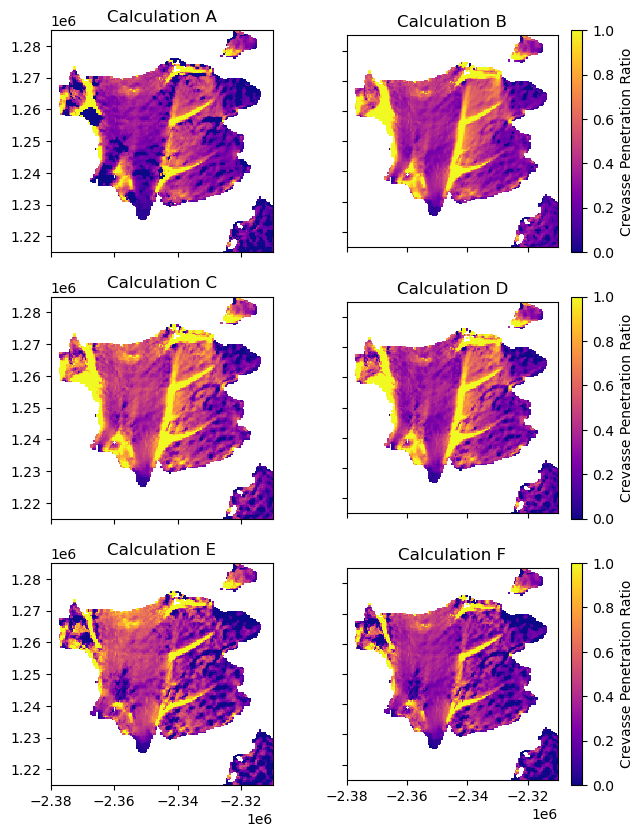

In [5]:
# Plot calculations A through F

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(7.5,10))

axs[0,0].pcolor(X, Y, pen_rat_A, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[0,0].set_title('Calculation A')
axs[0,0].set_aspect('equal')

pcmB = axs[0,1].pcolor(X, Y, pen_rat_B, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[0,1].set_title('Calculation B')
axs[0,1].set_aspect('equal')
fig.colorbar(pcmB, ax=axs[0,1], label='Crevasse Penetration Ratio')

axs[1,0].pcolor(X, Y, pen_rat_C, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[1,0].set_title('Calculation C')
axs[1,0].set_aspect('equal')

pcmD = axs[1,1].pcolor(X, Y, pen_rat_D, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[1,1].set_title('Calculation D')
axs[1,1].set_aspect('equal')
fig.colorbar(pcmD, ax=axs[1,1], label='Crevasse Penetration Ratio')

axs[2,0].pcolor(X, Y, pen_rat_E, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[2,0].set_title('Calculation E')
axs[2,0].set_aspect('equal')

pcmF = axs[2,1].pcolor(X, Y, pen_rat_F, vmin=0.0, vmax=1.0, shading='nearest', cmap=plt.cm.plasma)
axs[2,1].set_title('Calculation F')
axs[2,1].set_aspect('equal')
fig.colorbar(pcmF, ax=axs[2,1], label='Crevasse Penetration Ratio')
axs[2,1].set_xlim(x_min, x_max)
axs[2,1].set_ylim(y_min, y_max)

(1215000.0, 1285000.0)

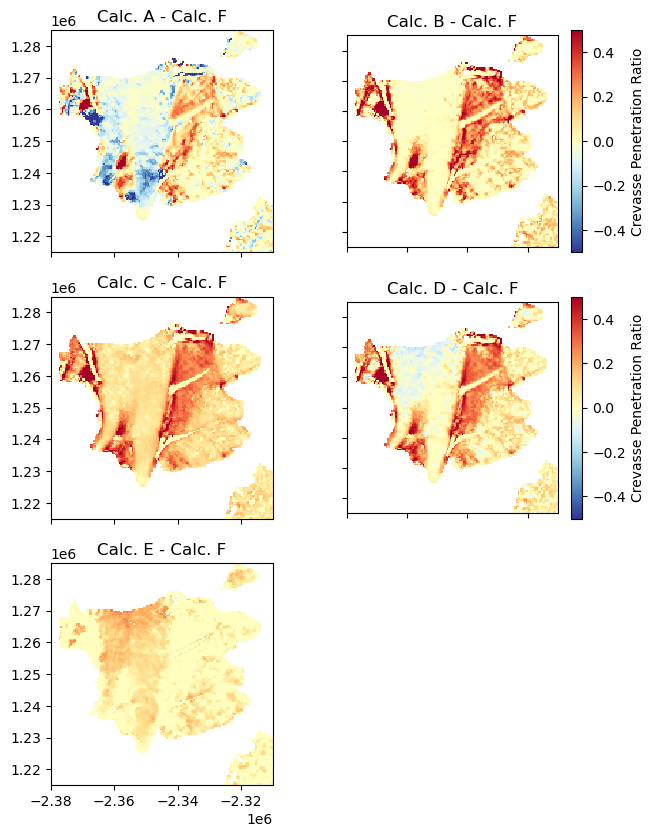

In [6]:
# Plot calculations A through F

div_cmap = plt.cm.RdYlBu
div_cmap = div_cmap.reversed()

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(7.5,10))

axs[0,0].pcolor(X, Y, pen_rat_A-pen_rat_F, vmin=-0.5, vmax=0.5, shading='nearest', cmap=div_cmap)
axs[0,0].set_title('Calc. A - Calc. F')
axs[0,0].set_aspect('equal')

pcmB = axs[0,1].pcolor(X, Y, pen_rat_B-pen_rat_F, vmin=-0.5, vmax=0.5, shading='nearest', cmap=div_cmap)
axs[0,1].set_title('Calc. B - Calc. F')
axs[0,1].set_aspect('equal')
fig.colorbar(pcmB, ax=axs[0,1], label='Crevasse Penetration Ratio')

axs[1,0].pcolor(X, Y, pen_rat_C-pen_rat_F, vmin=-0.5, vmax=0.5, shading='nearest', cmap=div_cmap)
axs[1,0].set_title('Calc. C - Calc. F')
axs[1,0].set_aspect('equal')

pcmD = axs[1,1].pcolor(X, Y, pen_rat_D-pen_rat_F, vmin=-0.5, vmax=0.5, shading='nearest', cmap=div_cmap)
axs[1,1].set_title('Calc. D - Calc. F')
axs[1,1].set_aspect('equal')
fig.colorbar(pcmD, ax=axs[1,1], label='Crevasse Penetration Ratio')

axs[2,0].pcolor(X, Y, pen_rat_E-pen_rat_F, vmin=-0.5, vmax=0.5, shading='nearest', cmap=div_cmap)
axs[2,0].set_title('Calc. E - Calc. F')
axs[2,0].set_aspect('equal')

axs[2,1].axis("off")

axs[0,0].set_xlim(x_min, x_max)
axs[0,0].set_ylim(y_min, y_max)